# 8. 수도권 아파트 가격 예측

- 빅데이터 수집 및 전처리 방법을 이해한다.
- 머신러닝 앙상블 알고리즘 중 XGBoost에 대해 이해한다.
- 랜덤 포레스트와 XGBoost 알고리즘으로 아파트 매매 가격 예측 인공지능 모델을 제작 및 비교한다.

#Kaggle 데이터 불러오기

➊ 데이터 세트를 제공하는 플랫폼인 캐글(kaggle)을 통해  오픈 API를 이용하여 데이터 불러오기

 캐글 홈페이지(www.kaggle.com)에 접속 -> 로그인 -> 오른쪽 상단의 프로필 ‘Your Profile’
-> Your Profile에 들어가 ‘Edit Public Profile’ 클릭 -> API 탭의 ‘Create New API Token’ 을 클릭  
-> ‘kaggle.json’을 다운로드


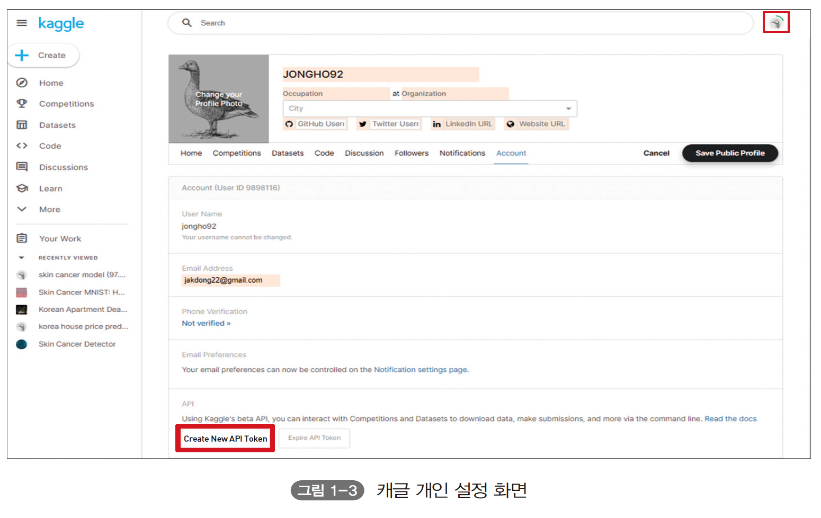

➋ 다음과 같이 캐글 모듈을 설치한 후 kaggle.json 파일을 업로드하고 해당 파일과 캐글을 연결하면 코랩과 캐글 사이트가 연동된다.

In [1]:
#kaggle 모듈 설치 및 json 파일 업로드
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jongho92","key":"970a42cb7650cfec7146834a2cb33e86"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

➌ 우리나라 아파트 거래 데이터를 가져오기
  - 캐글에서 ‘Korean Apartment Deal Data’를 검색한 후 오른쪽 상단 세로 3개 점 아이콘을
    클릭하여 API Command를 복사


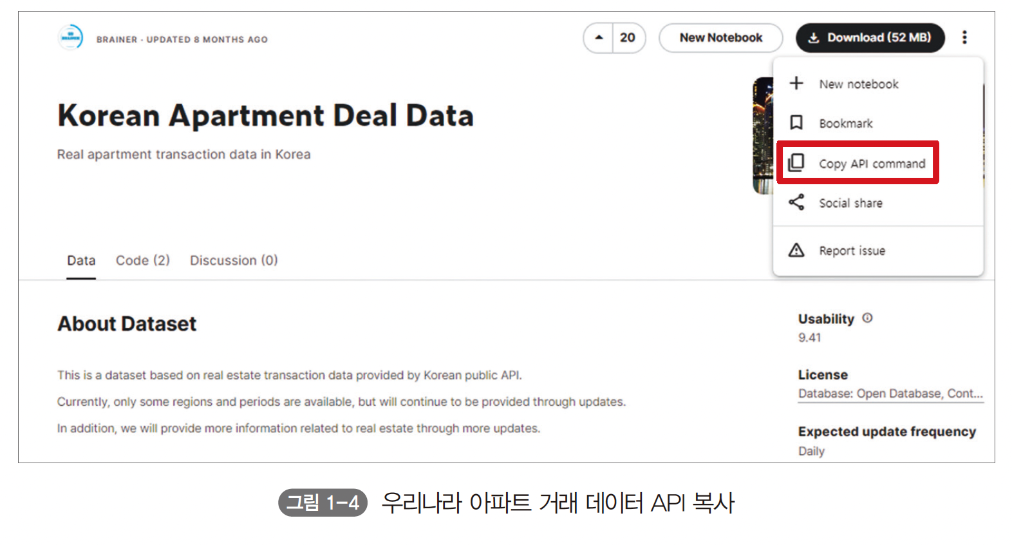

In [3]:
#한국 아파트 거래 가격 데이터 연결
!kaggle datasets download -d brainer3220/korean-real-estate-transaction-data
!unzip korean-real-estate-transaction-data
!ls

Dataset URL: https://www.kaggle.com/datasets/brainer3220/korean-real-estate-transaction-data
License(s): DbCL-1.0
 96% 57.0M/59.2M [00:00<00:00, 95.8MB/s]
100% 59.2M/59.2M [00:00<00:00, 93.4MB/s]
Archive:  korean-real-estate-transaction-data.zip
  inflating: Apart Deal.csv          
'Apart Deal.csv'   kaggle.json	 korean-real-estate-transaction-data.zip   sample_data


➍ 우리나라 아파트 거래 데이터를 가져오기
  -  필요한 모듈을 가져오고 ‘Apart Deal.csv’ 파일을 판다스를 통해 불러온다.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
url ='/content/Apart Deal.csv'
df = pd.read_csv(url, delimiter=",")

<ipython-input-5-09b0aa2f67f8>:2: DtypeWarning: Columns (6,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url, delimiter=",")


❺ 데이터 확인하기
 - 법정동, 거래일, 아파트 종류, 지번 등 9개의 속성으로 이루어진  총 434만 8,785개의 우리나라 아파트
거래 데이터를 확인할 수 있음

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5002839 entries, 0 to 5002838
Data columns (total 9 columns):
 #   Column  Dtype  
---  ------  -----  
 0   지역코드    float64
 1   법정동     object 
 2   거래일     object 
 3   아파트     object 
 4   지번      object 
 5   전용면적    float64
 6   층       object 
 7   건축년도    float64
 8   거래금액    object 
dtypes: float64(3), object(6)
memory usage: 343.5+ MB


In [7]:
df.head()

지역코드  법정동             거래일       아파트     지번      전용면적   층    건축년도   거래금액
0  31110.0  학성동  5/30/2020 0:00    남운학성타운    379  135.5800   8  1991.0  26700
1  31110.0  남외동   1/3/2020 0:00  남외푸르지오1차  506-1  101.6000   2  2006.0  35500
2  31110.0  남외동   1/3/2020 0:00     에일린의뜰    500   84.9920  11  2007.0  36500
3  31110.0  남외동   1/3/2020 0:00  남외푸르지오1차  506-1  118.7060   8  2006.0  43000
4  31110.0  남외동   1/4/2020 0:00  남외푸르지오2차  501-1   84.9636   7  2007.0  38700

In [8]:
df['지역코드'] = df['지역코드'].astype(int)

##우리나라 아파트 거래 데이터 전처리하기

➊ 불필요한 내용 제거
- 데이터에서 ‘법정동’은 지역 코드로 구분 가능하고 ‘아파트’(아파트 이름)와 ‘지번’은 가격 예측에 불필요하다고 판단되어 모두 삭제
- 법정동 코드 다섯 자리로 나타낸 ‘지역’ 데이터를 앞의 두 자리와 나머지 뒤의 세 자리로 구분


In [9]:
#법정동은 지역코드로 구분가능
#아파트 이름과 지번은 가격 예측에 불필요
df = df.drop(['법정동', '아파트', '지번'], axis= 1)

In [10]:
#지역코드를 구분
#areacode는 시/도
#gecode는 군/읍/면/동/구
areacode= []
gecode = []
for code in df['지역코드'] :
  acode = str(code)[0:2]
  gcode = str(code)[2:]
  areacode.append(int(acode))
  gecode.append(int(gcode))
df['지역'] = gecode
df['지역코드'] = areacode

➋ 수도권 데이터 구성
- 서울특별시의 법정동 코드는 11, 경기도의 법정동 코드는 41
- 서울과 경기도 데이터만 가져오기

In [11]:
#서울시의 지역코드는 '11'
df2 = df[df['지역코드']==11]
#경기도의 지역코드는 '41'
df3 = df2[df2['지역코드'] == 41]

In [12]:
df = pd.concat([df2, df3])

In [13]:
df.head()

지역코드        거래일    전용면적   층    건축년도    거래금액   지역
655312    11  1/13/2018  140.78  15  2004.0  130000  110
655313    11  1/19/2018  103.77   5  2003.0   96000  110
655314    11  1/23/2018  123.13  10  2004.0  118000  110
655315    11  1/30/2018   66.96  13  1994.0   54500  110
655316    11  1/31/2018   76.66  11  1994.0   64000  110

➌ ‘거래일' 데이터 형식 통일
- ‘거래일’의 데이터 형식을 모두 ‘20150000’ 형식으로 통일하고, 후에 카테고리 데이터로 설정하여 예측에 용이한 형태로 변환될 수 있도록 구성




In [14]:
import re

In [15]:
#날짜 형식 변경
#'1/31/2018'을 '20180118'로 변경
day = []
for date in df['거래일'] :
  date = date.split(' ')
  date = date[0]
  date = re.split('/|-', date)
  if len(date[0]) == 4 :
    date = int(date[0]+date[1]+date[2])
  else :
    if len(date[0]) == 1 :
      date[0] = '0'+date[0]
      if len(date[1]) == 1 :
        date[1] = '0'+date[1]
    date = int(date[2]+date[0]+date[1])
  day.append(date)
df['거래일']=day

In [16]:
df.tail()

지역코드       거래일   전용면적    층    건축년도    거래금액   지역
4704692    11  20230416  49.82  7.0  2020.0  60,000  740
4704693    11  20230420  84.83  5.0  2009.0  86,000  740
4704694    11  20230421  84.53  8.0  2009.0  85,000  740
4704695    11  20230422  84.53  8.0  2009.0  84,000  740
4704696    11  20230422  49.82  7.0  2020.0  61,000  740

➍ 거래 금액을 일반적인 숫자형 데이터로 변환
- 모두 문자형으로 변환한 후 replace( ) 함수로 ,(콤마)를 지우고 다시 숫자형으로 변환해 준다.
- 마지막으로 층의 Null 값을 0으로 채워 준다.


In [17]:
#거래금액 콤마(,) 제거
df['거래금액'] = df['거래금액'].astype('str')
df['거래금액'] = df['거래금액'].str.replace(',','')
df['거래금액'] = df['거래금액'].astype('int')

In [18]:
#층이 비어있으면 '0'을 넣어 결측치 제거
df['층'] = pd.to_numeric(df['층'], errors='coerce').fillna(0)

❺ 학습이 용이하도록 알맞은 형태로 변환

In [19]:
df['지역코드'] = df['지역코드'].astype('category')
df['지역'] = df['지역'].astype('category')
df['건축년도'] = df['건축년도'].astype('category')
df['거래일'] = df['거래일'].astype('category')
df['층'] = df['층'].astype('category')
df = df[['지역코드', '지역', '건축년도', '거래일', '층', '전용면적', '거래금액']]

In [20]:
df.sort_values(by=['지역'], axis=0)

지역코드   지역    건축년도       거래일   층    전용면적    거래금액
655312    11  110  2004.0  20180113  15  140.78  130000
2823844   11  110  2008.0  20160907   1   84.92   50000
2823845   11  110  2004.0  20160910  13  111.73   65900
2823846   11  110  2014.0  20160912  11   12.78   12000
2823847   11  110  2004.0  20160917  18   84.95   56700
...      ...  ...     ...       ...  ..     ...     ...
2279933   11  740  2002.0  20200113  11   84.43   60000
2279932   11  740  2004.0  20200111   5   84.97   59400
2279931   11  740  2019.0  20200111  27   59.11   94500
2279929   11  740  2019.0  20200111  18   49.68   91800
4704696   11  740  2020.0  20230422   7   49.82   61000

[630323 rows x 7 columns]

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 630323 entries, 655312 to 4704696
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype   
---  ------  --------------   -----   
 0   지역코드    630323 non-null  category
 1   지역      630323 non-null  category
 2   건축년도    630323 non-null  category
 3   거래일     630323 non-null  category
 4   층       630323 non-null  category
 5   전용면적    630323 non-null  float64 
 6   거래금액    630323 non-null  int64   
dtypes: category(5), float64(1), int64(1)
memory usage: 18.1 MB


#랜덤 포레스트 모델 생성 및 학습하기


➊ 필요 모듈 라이브러리 불러오기

- 머신러닝 모델인 랜덤 포레스트(Random Forest)를 사이킷런(sklearn) 라이브러리에서 불러오기
데이터를 훈련 데이터와 테스트 데이터로 효과적으로 분리하기 위해 train_test_split 모듈을 불러오고, 모델의 학습 정도를 높이고 성능 평가를 위해 k-fold 모듈과 cross_validation(교차 검증), metrics(평가 척도) 모듈을 불러오고 랜덤 seed도 설정


In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn import metrics

In [23]:
seed = 0
np.random.seed(seed)
seed = tf.random.set_seed(3)

❷ 훈련 데이터와 테스트 데이터 나누기
- 지역 코드, 지역, 건축년도, 거래일, 층, 전용 면적 속성이 독립 변수이므로 X에 저장
거래 금액 속성이 종속 변수이므로 Y에 저장
실거래가 데이터를 모델이 학습할 수 있는 형태인 넘파이(Numpy) 배열로 변환
8:2로 분할하여 각각 훈련 데이터 세트, 테스트 데이터 세트로 나누기

In [24]:
dataset = df.values
X = dataset[:,0:6]
Y = dataset[:,6]

X = np.asarray(X)
Y = np.asarray(Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=7)

❸ k-fold 및 랜덤 포레스트 모델 구성
- 학습의 정확도를 높이기 위해서 k-fold 모듈을 사용하여 훈련 데이터 세트를 다시 다섯 개로 나누어서 다섯 번의 학습을 진행
- 각각의 학습에서 다섯 개 중 네 개의 데이터 세트를 train set, 나머지 한 개의 데이터 세트를 validation set로 구분
- 각각의 데이터 세트를 모두 네 번씩 학습


In [25]:
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)
forest = RandomForestRegressor(n_estimators=100, random_state=seed, n_jobs= -1)

❹ k-fold와 랜덤 포레스트 모델 학습
- k-fold를 적용하여 학습을 진행하면서, 각 학습마다 평가 척도로 validation set의 RMSE
(Root Mean Squared Error, 평균제곱근오차)와 R2를 출력





In [26]:
for train, test in kfold.split(X_train,Y_train) :
  print("TRAIN:", train, "TEST:", test)
  x_train, x_test = X_train[train], X_train[test]
  y_train, y_test = Y_train[train], Y_train[test]

  forest.fit(x_train, y_train)

  y_pred = forest.predict(x_test)

  print('validation split rmse : {:.4f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))
  print('validation split R2 : {: .4f}'.format(metrics.r2_score(y_test, y_pred)))

TRAIN: [     0      1      2 ... 504255 504256 504257] TEST: [     5     12     13 ... 504236 504251 504252]
validation split rmse : 10340.4194
validation split R2 :  0.9604
TRAIN: [     0      1      3 ... 504254 504256 504257] TEST: [     2     11     17 ... 504214 504216 504255]
validation split rmse : 10300.5722
validation split R2 :  0.9616
TRAIN: [     1      2      3 ... 504255 504256 504257] TEST: [     0      6      8 ... 504239 504245 504249]
validation split rmse : 10441.8198
validation split R2 :  0.9607
TRAIN: [     0      1      2 ... 504252 504253 504255] TEST: [     3      7      9 ... 504254 504256 504257]
validation split rmse : 10641.2515
validation split R2 :  0.9595
TRAIN: [     0      2      3 ... 504255 504256 504257] TEST: [     1      4     21 ... 504242 504243 504253]
validation split rmse : 10719.8160
validation split R2 :  0.9580


- cross_validate 모듈을 이용하여 학습 후에 훈련 데이터가 학습이 잘 되었는지, 시간은 얼마나 걸렸는지를 확인

In [27]:
cross_validate(forest, X_train, Y_train, cv = kfold,
               scoring= ['r2'],return_train_score = True )

{'fit_time': array([20.55919743, 20.57216239, 20.5198679 , 20.28816509, 19.73864293]),
 'score_time': array([0.69955158, 0.74276042, 0.6993134 , 0.69812846, 0.74193454]),
 'test_r2': array([0.9602315 , 0.95995434, 0.96092284, 0.9599978 , 0.95811634]),
 'train_r2': array([0.9943402 , 0.99426731, 0.99431972, 0.99440846, 0.99434753])}

❺ K-fold와 랜덤 포레스트 모델 학습 평가
- k-fold와 cross_validate로 랜덤 포레스트 모델의 학습과 평가를 마친 후, 테스트 데이터를 모델에 적용시켜 최종적으로 학습이 잘 되었는지 평가
- 마찬가지로 평가 척도는 RMSE와 R2를 사용하는데, 상대적인 평가가 가능한 평가 척도인 R2 결과가 0.95가 넘는 것으로 보아 학습이 잘 이루어졌음을 판단





In [28]:
print("테스트 세트 정확도: {:.3f}".format(forest.score(X_test, Y_test)))
pred = forest.predict(X_test)
print('rmse : {:.4f}'.format(np.sqrt(metrics.mean_squared_error(Y_test, pred))))
print('R2 : {:.4f}'.format(metrics.r2_score(Y_test, pred)))

테스트 세트 정확도: 0.960
rmse : 10427.6545
R2 : 0.9597


❻ 테스트 데이터로 가격 예측
- 마지막으로 학습을 거치지 않은 낯선 데이터는 테스트 데이터를 넣고 예측할 가격과 비교

In [29]:
for i in range(0,20) :
  print('실제 아파트 가격 : %d만원, 예측 아파트 가격 : %d만원' %(Y_test[i], pred[i]))

실제 아파트 가격 : 60000만원, 예측 아파트 가격 : 59176만원
실제 아파트 가격 : 125000만원, 예측 아파트 가격 : 104917만원
실제 아파트 가격 : 153000만원, 예측 아파트 가격 : 147863만원
실제 아파트 가격 : 74500만원, 예측 아파트 가격 : 73582만원
실제 아파트 가격 : 70000만원, 예측 아파트 가격 : 69960만원
실제 아파트 가격 : 355000만원, 예측 아파트 가격 : 361099만원
실제 아파트 가격 : 21500만원, 예측 아파트 가격 : 19539만원
실제 아파트 가격 : 59500만원, 예측 아파트 가격 : 60072만원
실제 아파트 가격 : 89000만원, 예측 아파트 가격 : 128650만원
실제 아파트 가격 : 28500만원, 예측 아파트 가격 : 31320만원
실제 아파트 가격 : 135500만원, 예측 아파트 가격 : 117752만원
실제 아파트 가격 : 37750만원, 예측 아파트 가격 : 38884만원
실제 아파트 가격 : 68300만원, 예측 아파트 가격 : 67309만원
실제 아파트 가격 : 220000만원, 예측 아파트 가격 : 158795만원
실제 아파트 가격 : 360000만원, 예측 아파트 가격 : 361120만원
실제 아파트 가격 : 30700만원, 예측 아파트 가격 : 32888만원
실제 아파트 가격 : 50000만원, 예측 아파트 가격 : 57162만원
실제 아파트 가격 : 133500만원, 예측 아파트 가격 : 123265만원
실제 아파트 가격 : 79500만원, 예측 아파트 가격 : 81560만원
실제 아파트 가격 : 45900만원, 예측 아파트 가격 : 45201만원


#XGBoost 모델 생성 및 학습하기

➊ XGBoost 모델 설정
- 의사결정 트리 기반의 Boost 모델인 XGBoost 알고리즘으로 학습
- XGBoost는 자체 오픈 소스 라이브러리로 불러오기


In [30]:
import xgboost
from xgboost import XGBRegressor

- k-fold를 적용하여 학습을 진행하고 XGBoost 모델을 구성
- XGBoost 모델은 랜덤 포레스트 알고리즘의 매개 변수와 동일하며 학습률(learning_rate)을 조절할 수 있는데, 여기서는 가장 일반적인 0.1로 설정

In [31]:
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)
xgb = XGBRegressor(max_depth=20,learning_rate=0.1, n_estimators=100, n_jobs=-1)

➊ XGBoost 모델 설정

In [32]:
for train, test in kfold.split(X_train,Y_train) :
  print("TRAIN:", train, "TEST:", test)
  x_train, x_test = X_train[train], X_train[test]
  y_train, y_test = Y_train[train], Y_train[test]

  xgb.fit(x_train, y_train)

  y_pred2 = xgb.predict(x_test)

  print('validation split rmse : {:.4f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred2))))
  print('validation split R2 : {: .4f}'.format(metrics.r2_score(y_test, y_pred2)))

TRAIN: [     0      1      2 ... 504254 504256 504257] TEST: [     8     23     26 ... 504239 504247 504255]
validation split rmse : 11093.7525
validation split R2 :  0.9552
TRAIN: [     0      2      3 ... 504254 504255 504256] TEST: [     1      7      9 ... 504236 504249 504257]
validation split rmse : 10989.9304
validation split R2 :  0.9557
TRAIN: [     0      1      2 ... 504255 504256 504257] TEST: [     5      6     11 ... 504242 504251 504252]
validation split rmse : 11169.8174
validation split R2 :  0.9553
TRAIN: [     1      3      5 ... 504252 504255 504257] TEST: [     0      2      4 ... 504253 504254 504256]
validation split rmse : 10988.5427
validation split R2 :  0.9562
TRAIN: [     0      1      2 ... 504255 504256 504257] TEST: [     3     14     20 ... 504246 504248 504250]
validation split rmse : 11460.6358
validation split R2 :  0.9523


❷ XGBoost 모델 학습




In [33]:
cross_validate(xgb, X_train, Y_train, cv = kfold, scoring= ['r2'],return_train_score = True )

{'fit_time': array([29.82706809, 28.89979458, 30.24558043, 29.40402341, 29.70715714]),
 'score_time': array([0.6573751 , 0.63805676, 0.42956591, 0.44818091, 0.45210147]),
 'test_r2': array([0.9570216 , 0.95467261, 0.9548025 , 0.95590516, 0.95519411]),
 'train_r2': array([0.99910818, 0.9991552 , 0.99910621, 0.99901781, 0.99907831])}

In [34]:
print("테스트 세트 정확도: {:.3f}".format(xgb.score(X_test, Y_test)))
pred2 = xgb.predict(X_test)
print('rmse : {:.4f}'.format(np.sqrt(metrics.mean_squared_error(Y_test, pred2))))
print('R2 : {:.4f}'.format(metrics.r2_score(Y_test, pred2)))

테스트 세트 정확도: 0.954
rmse : 11100.4942
R2 : 0.9544


❸ XGBoost 모델 테스트
- 테스트 데이터로 평가하고 20개의 가격을 예측

In [35]:
for i in range(0,20) :
  print('실제 아파트 가격 : %d만원, 예측 아파트 가격 : %d만원' %(Y_test[i], pred2[i]))

실제 아파트 가격 : 60000만원, 예측 아파트 가격 : 53458만원
실제 아파트 가격 : 125000만원, 예측 아파트 가격 : 116987만원
실제 아파트 가격 : 153000만원, 예측 아파트 가격 : 148359만원
실제 아파트 가격 : 74500만원, 예측 아파트 가격 : 72248만원
실제 아파트 가격 : 70000만원, 예측 아파트 가격 : 63117만원
실제 아파트 가격 : 355000만원, 예측 아파트 가격 : 378719만원
실제 아파트 가격 : 21500만원, 예측 아파트 가격 : 18941만원
실제 아파트 가격 : 59500만원, 예측 아파트 가격 : 59562만원
실제 아파트 가격 : 89000만원, 예측 아파트 가격 : 130070만원
실제 아파트 가격 : 28500만원, 예측 아파트 가격 : 31378만원
실제 아파트 가격 : 135500만원, 예측 아파트 가격 : 131760만원
실제 아파트 가격 : 37750만원, 예측 아파트 가격 : 36590만원
실제 아파트 가격 : 68300만원, 예측 아파트 가격 : 67431만원
실제 아파트 가격 : 220000만원, 예측 아파트 가격 : 169829만원
실제 아파트 가격 : 360000만원, 예측 아파트 가격 : 359545만원
실제 아파트 가격 : 30700만원, 예측 아파트 가격 : 34689만원
실제 아파트 가격 : 50000만원, 예측 아파트 가격 : 50335만원
실제 아파트 가격 : 133500만원, 예측 아파트 가격 : 135964만원
실제 아파트 가격 : 79500만원, 예측 아파트 가격 : 79890만원
실제 아파트 가격 : 45900만원, 예측 아파트 가격 : 46045만원


❹ 랜덤 포레스트와 XGBoost 모델 비교 시각화

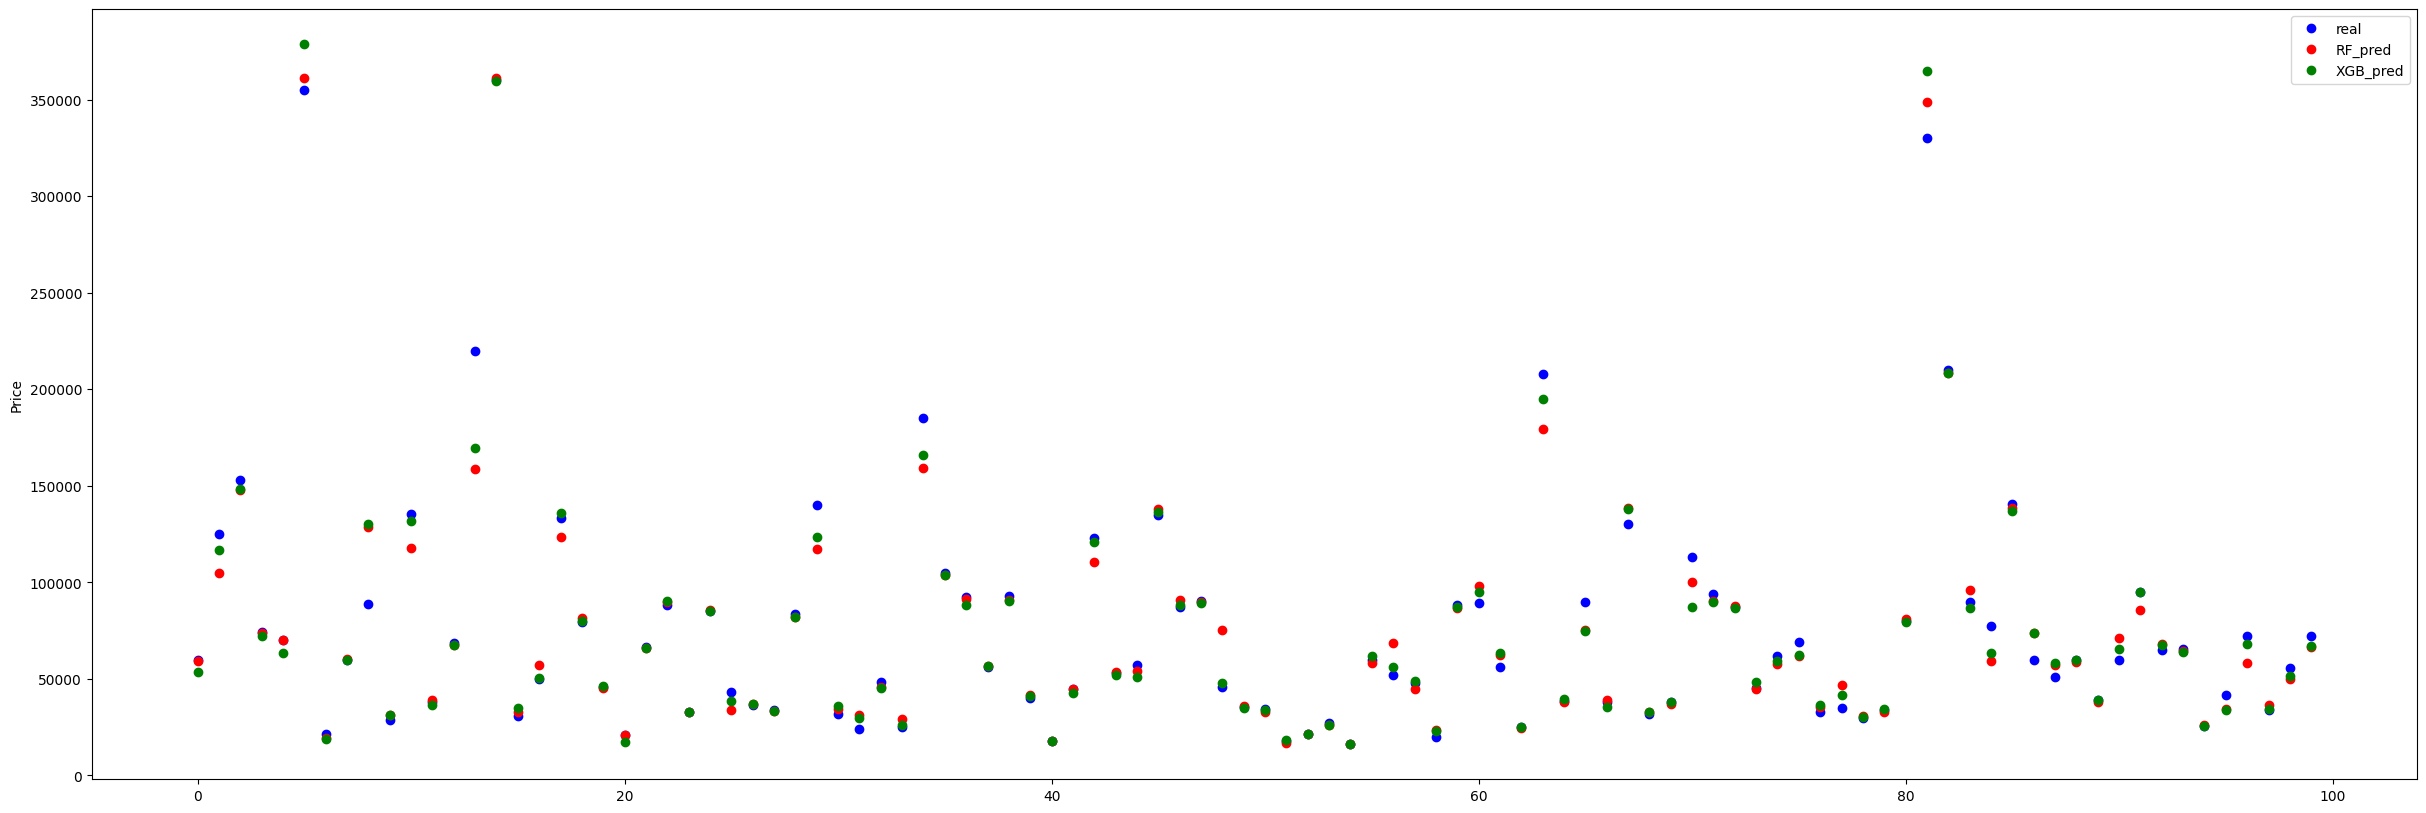

In [36]:
plt.figure(figsize=(30, 10))
plt.plot(Y_test[0:100],'bo', label='real')
plt.plot(pred[0:100],'ro', label='RF_pred')
plt.plot(pred2[0:100],'go', label='XGB_pred')
plt.ylabel('Price')
plt.legend()
plt.show()

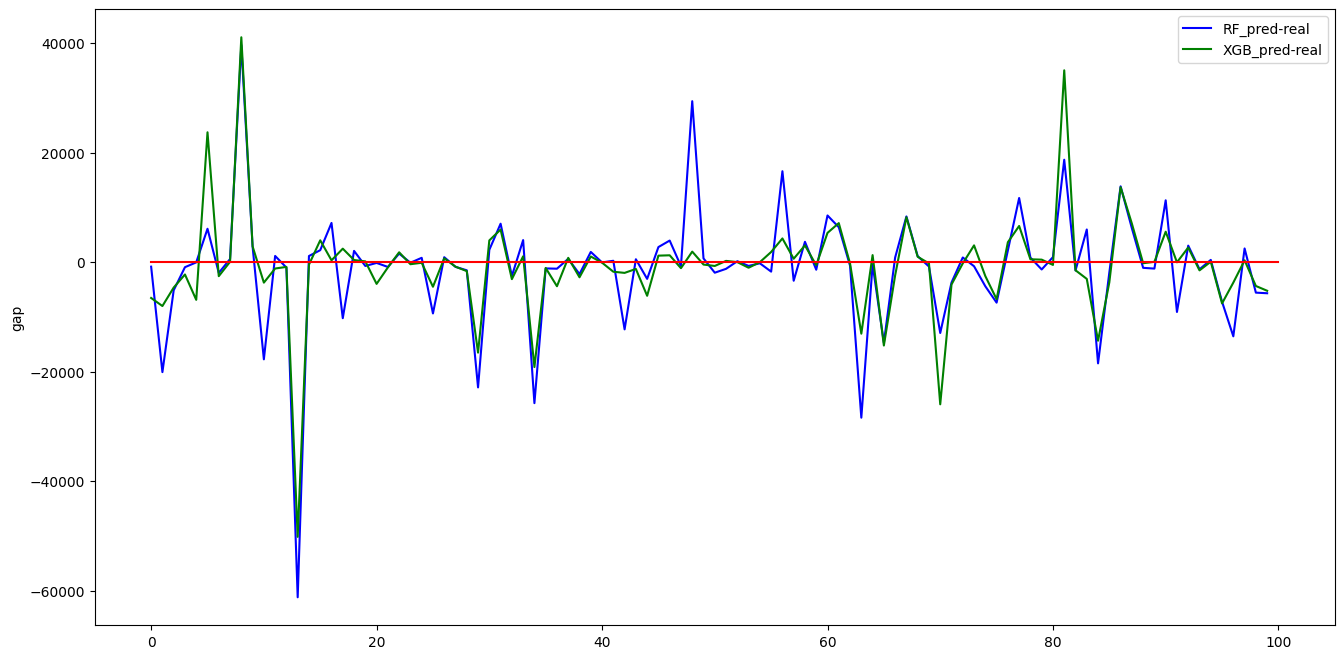

In [37]:
plt.figure(figsize=(16, 8))
plt.plot(pred[0:100]-Y_test[0:100],'b-', label='RF_pred-real')
plt.plot(pred2[0:100]-Y_test[0:100], 'g-', label='XGB_pred-real')
plt.plot([0,100],[0,0],'r-')
plt.ylabel('gap')
plt.legend()
plt.show()